In [53]:
import numpy as np
import pandas as pd
import suncalc
from scipy import stats
import scipy
import datetime as dt

import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches
from pathlib import Path

In [2]:
import sys

sys.path.append("../src")
sys.path.append("../src/activity")

In [3]:
from core import SITE_NAMES, FREQ_GROUPS, SEATTLE_LATITUDE, SEATTLE_LONGITUDE, DC_COLOR_MAPPINGS
from cli import get_file_paths

import subsampling as ss
import plot
import pipeline
import activity_assembly as actvt

In [4]:
avail = np.arange(0, 720, 6) + 6
reset_24 = avail[np.where((24*60 % avail) == 0)[0]]
reset_24

array([  6,  12,  18,  24,  30,  36,  48,  60,  72,  90,  96, 120, 144,
       180, 240, 288, 360, 480, 720])

In [47]:
cycle_lengths = reset_24
percent_ons = [1/6, 1/3, 1/2, 2/3]
specific_dc_tag = "30of30"

pipeline_params = dict()
pipeline_params['assemble_location_summary'] = False
pipeline_params["read_csv"] = False
pipeline_params['use_threshold_to_group'] = False
pipeline_params['use_kmeans_to_group'] = True
pipeline_params["save_activity_grid"] = False
pipeline_params["save_presence_grid"] = False
pipeline_params["save_dc_night_comparisons"] = False
pipeline_params["save_activity_dc_comparisons"] = False
pipeline_params["save_presence_dc_comparisons"] = False
pipeline_params["show_plots"] = True
pipeline_params["show_PST"] = True

data_params = dict()
data_params["cycle_lengths"] = cycle_lengths
data_params["percent_ons"] = percent_ons
dc_tags = ss.get_list_of_dc_tags(data_params["cycle_lengths"], data_params["percent_ons"])
data_params["dc_tags"] = dc_tags
data_params["cur_dc_tag"] = specific_dc_tag
data_params['bin_size'] = '30'
data_params['index_time_block_in_secs'] = '5'
data_params['recording_start'] = '05:00'
data_params['recording_end'] = '10:00'

site_keys = ['Carp']
type_keys = ['', 'LF', 'HF']
site_key = site_keys[0]
type_key = 'LF'
print(site_key, type_key)

data_params["site_name"] = SITE_NAMES[site_key]
data_params["site_tag"] = site_key
data_params["type_tag"] = type_key

file_paths = get_file_paths(data_params)

activity_inds_arr = pd.DataFrame()

# for dc_tag in data_params['dc_tags']:
dc_tag = data_params['cur_dc_tag']
location_df = ss.prepare_summary_for_plotting_with_duty_cycle(file_paths, dc_tag, data_params['bin_size'])

Carp LF


In [50]:
location_df['ref_time'] = location_df['call_start_time']
temp = location_df.resample(f'{data_params["index_time_block_in_secs"]}S', on='ref_time')['ref_time'].count()
temp[temp>0] = 1
activity_indices = temp.resample(f"{data_params['index_time_block_in_secs']}S").sum()
col_name = f"activity_index ({dc_tag})"
incomplete_activity_arr = pd.DataFrame(activity_indices.values, index=activity_indices.index, columns=[col_name])
incomplete_activity_arr

,activity_index (30of30)
ref_time,
2022-07-13 05:00:00,0
2022-07-13 05:00:05,0
2022-07-13 05:00:10,0
2022-07-13 05:00:15,0
2022-07-13 05:00:20,0
...,...
2022-10-17 09:59:35,0
2022-10-17 09:59:40,0
2022-10-17 09:59:45,0


In [49]:
incomplete_activity_arr

,activity_index (30of30)
ref_time,
2022-07-13 04:30:00,6
2022-07-13 05:00:00,8
2022-07-13 05:30:00,33
2022-07-13 06:00:00,19
2022-07-13 06:30:00,10
...,...
2022-10-17 08:00:00,0
2022-10-17 08:30:00,0
2022-10-17 09:00:00,1


In [7]:
df2 = pd.pivot_table(incomplete_activity_arr, index=(incomplete_activity_arr.index.date), 
                     columns=incomplete_activity_arr.index.time, 
                     values='activity_index (30of30)')

df2.columns = np.arange(len(df2.columns))
df2.index = np.arange(len(df2.index))
xd, yd = np.meshgrid(df2.columns, df2.index)
y_inds = df2.index

In [8]:
(df2==1).iloc[y_inds]

,0,1,2,3,4,5,6,7,8,9,...,17270,17271,17272,17273,17274,17275,17276,17277,17278,17279
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
93,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
94,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
95,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


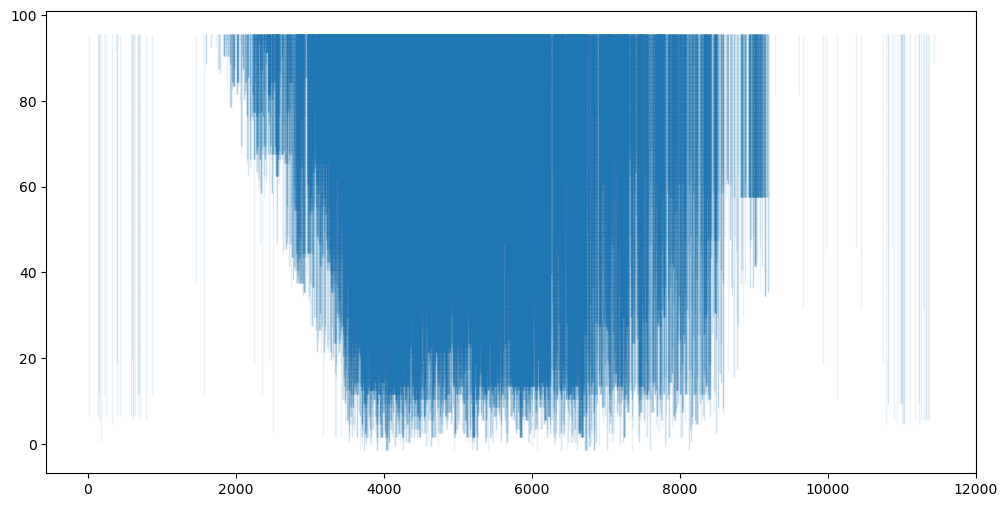

In [25]:
plt.figure(figsize=(12, 6))
pos = []
for y in y_inds:
    x_inds = xd[y, (df2==1).iloc[y]]
    for x in x_inds:
        pos += [x]
    plt.eventplot(pos, linelengths=1, linewidths=1,lineoffsets=y-1, alpha=0.1)

plt.show()